In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge
import lightgbm as lgb

from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_log_error

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [4]:
class TargetOrderEncode:
    def __init__(self):
        pass
    
    def fit_and_transform(self, train, feature):
        self.feature = feature
        self.ordering = pd.DataFrame()
        self.ordering['val'] = train[feature].unique()
        self.ordering.index = self.ordering.val
        self.ordering['spmean'] = train[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
        self.ordering = self.ordering.sort_values('spmean')
        self.ordering['ordering'] = range(1, self.ordering.shape[0]+1)
        self.ordering = self.ordering['ordering'].to_dict()

        self.transform(train)

    def transform(self, test):
        for cat, o in self.ordering.items():
            test.loc[test[self.feature] == cat, self.feature+'_E'] = o

In [5]:
qual_encoded = []
for q in qualitative:
    encoder = TargetOrderEncode()
    encoder.fit_and_transform(train, q)
    encoder.transform(test)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [6]:
log_features = [
    'GrLivArea',
    '1stFlrSF',
    '2ndFlrSF',
    'TotalBsmtSF',
    'LotArea',
    'LotFrontage',
    'KitchenAbvGr',
    'GarageArea'
]

quad_feats = [
    'OverallQual',
    'YearBuilt',
    'YearRemodAdd',
    'TotalBsmtSF',
    '2ndFlrSF',
    'Neighborhood_E',
    'RoofMatl_E',
    'GrLivArea'
]

qdr = [f+'2' for f in quad_feats]

In [7]:
def log_transform(df, feature):
    df[feature] = np.log1p(df[feature].values)

def quadratic(df, feature):
    df[feature+'2'] = df[feature]**2

def bool_encode(train):
    train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
    train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
    train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
    train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

In [8]:
for f in quad_feats:
    quadratic(train, f)
    quadratic(test, f)

for f in log_features:
    log_transform(train, f)
    log_transform(test, f)

bool_encode(train)
bool_encode(test)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']

features = quantitative + qual_encoded + boolean + qdr

In [9]:
def error(actual, predicted):
    return np.sqrt(mean_squared_log_error(actual, predicted))

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=216)

## Ridge

In [29]:
X = train[features].fillna(0.).values
Y = train['SalePrice'].values

models = []
Ypred = np.zeros_like(Y)

for train_index, val_index in kf.split(X):
    X_tr = X[train_index]
    X_val = X[val_index]
    y_tr = Y[train_index]
    y_val = Y[val_index]
    
    ridge = Ridge()
    ridge.fit(X_tr, np.log(y_tr))
    
    y_pred = np.exp(ridge.predict(X_val))
    Ypred[val_index] = y_pred
    
    print(error(y_val, y_pred))
    
    models.append(ridge)

0.11205509234113975
0.13071949887035056
0.1169484041791938
0.12753968125947115
0.11915025549134804


/home/ksaw/.cache/pypoetry/virtualenvs/house-price-PNXQfjFB-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.05281e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/ksaw/.cache/pypoetry/virtualenvs/house-price-PNXQfjFB-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.00631e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [30]:
error(Y, Ypred)

0.12147756793269066

In [31]:
submissions = pd.DataFrame()

submissions['Ridge'] = Ypred

## LGBM

In [23]:
params = {
    'application': 'root_mean_squared_error',
    'boosting': 'gbdt',
    # 'metric': 'multi_error',
    'num_leaves': 15,
    'max_depth': 4,
    'learning_rate': 0.01,
    'bagging_fraction': 0.85,
    'feature_fraction': 0.8,
    'min_split_gain': 0.02,
    'min_child_samples': 150,
    'min_child_weight': 0.02,
    'lambda_l2': 0.01,
    'lambda_l2': 0.01,
    'verbosity': -1,
    'seed': 477,
}

early_stop = 500
verbose_eval = 100
num_rounds = 90000
# n_splits = 5

In [26]:
X = train[features].values
Y = train['SalePrice'].values

models = []
Ypred = np.zeros_like(Y)

for i, (train_index, val_index) in enumerate(kf.split(X)):
    X_tr = X[train_index]
    X_val = X[val_index]
    y_tr = Y[train_index]
    y_val = Y[val_index]
    
    d_train = lgb.Dataset(X_tr, label=np.log(y_tr))
    d_valid = lgb.Dataset(X_val, label=np.log(y_val))
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(
        params,
        train_set=d_train,
        num_boost_round=num_rounds,
        valid_sets=watchlist,
        verbose_eval=verbose_eval,
        early_stopping_rounds=early_stop
    )
    
    y_pred = np.exp(model.predict(X_val, num_iteration=model.best_iteration))
    Ypred[val_index] = y_pred
    
    print(error(y_val, y_pred))
    
    models.append(model)

training LGB:
Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 0.236479	valid_1's rmse: 0.235013
[200]	training's rmse: 0.175946	valid_1's rmse: 0.181263
[300]	training's rmse: 0.152389	valid_1's rmse: 0.16197
[400]	training's rmse: 0.141204	valid_1's rmse: 0.153218
[500]	training's rmse: 0.135727	valid_1's rmse: 0.149465
[600]	training's rmse: 0.132048	valid_1's rmse: 0.147875
[700]	training's rmse: 0.1292	valid_1's rmse: 0.146976
[800]	training's rmse: 0.126768	valid_1's rmse: 0.146222
[900]	training's rmse: 0.124671	valid_1's rmse: 0.145448
[1000]	training's rmse: 0.122921	valid_1's rmse: 0.144948
[1100]	training's rmse: 0.121309	valid_1's rmse: 0.144594
[1200]	training's rmse: 0.119755	valid_1's rmse: 0.144005
[1300]	training's rmse: 0.118566	valid_1's rmse: 0.143618
[1400]	training's rmse: 0.117678	valid_1's rmse: 0.14332
[1500]	training's rmse: 0.117678	valid_1's rmse: 0.14332
[1600]	training's rmse: 0.117678	valid_1's rmse: 0.14332
[1700]	trai

In [28]:
error(Y, Ypred)

0.14194676794700326

In [32]:
submissions['LGBM'] = Ypred

## モデルの相関

In [35]:
import seaborn as sns

<AxesSubplot:>

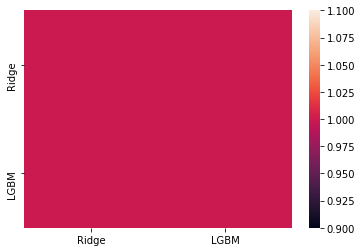

In [36]:
corr = submissions.corr()
sns.heatmap(corr)

## Submission

In [ ]:
X_test = test[features].fillna(0.).values

In [ ]:
test_preds = []

for m in models:
    test_pred = np.exp(m.predict(X_test))
    test_preds.append(test_pred)

test_preds = np.vstack(test_preds).mean(axis=0)

In [ ]:
submission = test[['Id']]

In [ ]:
submission['SalePrice'] = test_preds

In [ ]:
submission

In [ ]:
submission.to_csv('../output/base_line.csv', index=False)